In [8]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.random import sample_without_replacement
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import boruta
from boruta import BorutaPy

## Part 4: Data modeling

### Part 4.a Add in a target:

In [50]:
# Create a target variable is where there are 1+ unsafe building notices

permit_inspect_unsafe['target'] = 0
permit_inspect_unsafe.loc[permit_inspect_unsafe['unsafe_building']>0, 'target'] = 1

#Data clean up
permit_inspect_unsafe=permit_inspect_unsafe[permit_inspect_unsafe['permitnumber']!='461321`']
permit_inspect_unsafe[permit_inspect_unsafe['unsafe_building']==1].head(1)
print('This address has too many unsafe flags and is skewing the dataset:', permit_inspect_unsafe[permit_inspect_unsafe['addresskey']==461088].addresskey.count())

#Cleanup
permit_inspect_unsafe=permit_inspect_unsafe[permit_inspect_unsafe['addresskey']!=461088]

This address has too many unsafe flags and is skewing the dataset: 229


In [51]:
#Data cleanup

permit_inspect_unsafe.drop([ 'APPL','SITE','addresskey','permitnumber','unsafe_building'], axis=1, inplace=True)
permit_inspect_unsafe['target'] = permit_inspect_unsafe['target'].apply(np.float64)

permit_inspect_unsafe = permit_inspect_unsafe.loc[:,~permit_inspect_unsafe.columns.duplicated()]

permit_inspect_unsafe.fillna(0, inplace=True)

In [52]:
#Very skewed data:
print("original dataset's distribution:")
print ('shape: ', permit_inspect_unsafe.shape)
print(permit_inspect_unsafe.target.value_counts(normalize=True))

original dataset's distribution:
shape:  (251023, 170)
0.0    0.995578
1.0    0.004422
Name: target, dtype: float64


### Part 4.b Resample and reshape the data, as it is very skewed. Resampling: Undersample or Oversample?


### Part 4.b.1 Undersampling:

In [53]:
#Resample data:

permit_inspect_unsafe_0 = permit_inspect_unsafe.loc[permit_inspect_unsafe.target==0]
permit_inspect_unsafe_1 = permit_inspect_unsafe.loc[permit_inspect_unsafe.target==1]

# rebalance the training set so it has 50-50% for the target. 
# this has a random state, so it needs to be fixed to be able to reproduce results. 
ix = sample_without_replacement(n_population=permit_inspect_unsafe_0.shape[0],
                                n_samples=permit_inspect_unsafe_1.shape[0], 
                                random_state=42)

permit_inspect_unsafe_0 = permit_inspect_unsafe_0.iloc[ix]
permit_inspect_unsafe_undersample = pd.concat([permit_inspect_unsafe_0, permit_inspect_unsafe_1], ignore_index=True)

#shuffle dataframe so train/test split wont' get messed up 
permit_inspect_unsafe_undersample = shuffle(permit_inspect_unsafe_undersample)

permit_inspect_unsafe_undersample.reset_index(inplace=True, drop=True)

print ('\n')
print ('rebalanced statistisc: ')
print ('shape: ', permit_inspect_unsafe_undersample.shape)
permit_inspect_unsafe_undersample.target.value_counts(normalize=True)



rebalanced statistisc: 
shape:  (2220, 170)


0.0    0.5
1.0    0.5
Name: target, dtype: float64

##### Initial accuracy, recall, and confusion matrix:

In [54]:
# Separate input features and target
y = permit_inspect_unsafe_undersample.target
X = permit_inspect_unsafe_undersample.drop('target', axis=1)

# setting up testing and training sets
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(x_train, y_train)



#Validation Results
print('Validation Results')
print("Accuracy score test", clf_rf.score(x_val, y_val))
print("Recall score test", recall_score(y_val, clf_rf.predict(x_val)))

print ("roc_auc_score train", roc_auc_score(y_train, clf_rf.predict_proba(x_train)[:,1]))
print ("roc_auc_score test", roc_auc_score(y_val, clf_rf.predict_proba(x_val)[:,1]))

#Validation Results 2 (Just cause)
# make predictions for test data
y_pred = clf_rf.predict(x_val)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_val, predictions)
print("Accuracy score test: %.2f%%" % (accuracy * 100.0))

Validation Results
Accuracy score test 0.836036036036036
Recall score test 0.8333333333333334
roc_auc_score train 1.0
roc_auc_score test 0.9173939016155004
Accuracy score test: 83.60%


In [55]:
from sklearn.metrics import confusion_matrix
test_conf_matrix=confusion_matrix(y_val, y_pred)
test_conf_matrix = pd.DataFrame(test_conf_matrix)

test_conf_matrix.index=['true_negative', 'true_positive']
test_conf_matrix.columns=['pred_negative', 'pred_positive']
test_conf_matrix


,pred_negative,pred_positive
true_negative,234,45
true_positive,46,230


##### Visualizing the ROC curve:

In [56]:
# plot probability distribution

prediction = clf_rf.predict_proba(X=permit_inspect_unsafe_undersample.iloc[:,:-1])
prediction = pd.DataFrame(prediction).iloc[:,1]

permit_inspect_unsafe_undersample_t = permit_inspect_unsafe_undersample.copy()
permit_inspect_unsafe_undersample_t.reset_index(drop=True, inplace=True)
permit_inspect_unsafe_undersample_t['prediction'] = prediction

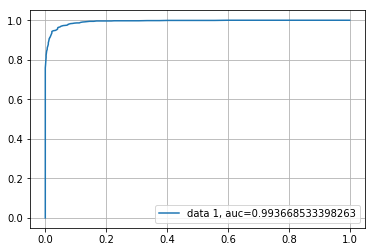

In [57]:
# visualize the ROC curve

fpr, tpr, _ = metrics.roc_curve(permit_inspect_unsafe_undersample_t.target, permit_inspect_unsafe_undersample_t.prediction)
auc = metrics.roc_auc_score(permit_inspect_unsafe_undersample_t.target, permit_inspect_unsafe_undersample_t.prediction)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.grid()
plt.show()

### Part 4.b.2 Oversampling using SMOTE:

In [58]:
from imblearn.over_sampling import SMOTE

# Separate input features and target
y = permit_inspect_unsafe.target
X = permit_inspect_unsafe.drop('target', axis=1)

# setting up testing and training sets
training_features, test_features,training_target, test_target, = train_test_split(X,y,
                                               test_size = .25,random_state=42)

By oversampling only on the training data, none of the information in the validation data is being used to create synthetic observations. So these results should be generalizable. 

In [59]:
#Oversampling on only the training data:
x_train, x_val, y_train, y_val = train_test_split(training_features, training_target,
                                                  test_size = .25,
                                                  random_state=42)

In [60]:
#SMOTE
sm = SMOTE(random_state=42, sampling_strategy ='auto')
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

print('shape:',x_train_res.shape)

shape: (281160, 169)


In [61]:
#Random Forest
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(x_train_res, y_train_res)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [62]:
print('Validation Results')
print("Accuracy:",clf_rf.score(x_val, y_val))
print ("Recall:",recall_score(y_val, clf_rf.predict(x_val)))
print( '\nTest Results')
print ("Accuracy:",clf_rf.score(test_features, test_target))
print ("Recall:",recall_score(test_target, clf_rf.predict(test_features)))

Validation Results
Accuracy: 0.9963031423290203
Recall: 0.21844660194174756

Test Results
Accuracy: 0.9964624896424247
Recall: 0.2535211267605634


### Part 4.b Conclusion: Based on the above results, I've chosen to undersample rather than use SMOTE

#### Interesting sidenote--charts showing how SMOTE resamples data:

Counter({0.0: 249913, 1.0: 1110})


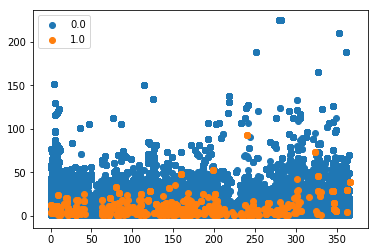

In [63]:
# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where

# define dataset
features = [f for f in permit_inspect_unsafe.columns if f not in ['target']]
X = permit_inspect_unsafe[features].values
y = permit_inspect_unsafe['target'].values.ravel()

# summarize class distribution
counter = Counter(y)
print(counter)

# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

Counter({0.0: 249913, 1.0: 249913})


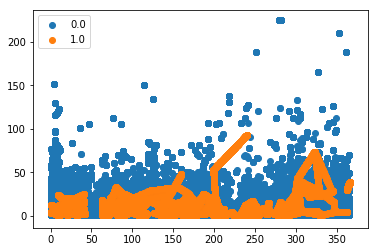

In [64]:
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)

# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

### Part 4.c Feature Selection & Clean Up:

In [65]:
#Random Forest model for boruta:

# rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
rf = RandomForestClassifier(random_state=42)
random_state=42

In [66]:
#Boruta feature selector with max iterations=150
import boruta
from boruta import BorutaPy

features = [f for f in permit_inspect_unsafe_undersample.columns if f not in ['target']]
len(features)

X = permit_inspect_unsafe_undersample[features].values
y = permit_inspect_unsafe_undersample['target'].values.ravel()

boruta_feature_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42, max_iter = 150, perc = 90)
boruta_feature_selector.fit(X, y)


Iteration: 	1 / 150
Confirmed: 	0
Tentative: 	169
Rejected: 	0
Iteration: 	2 / 150
Confirmed: 	0
Tentative: 	169
Rejected: 	0
Iteration: 	3 / 150
Confirmed: 	0
Tentative: 	169
Rejected: 	0
Iteration: 	4 / 150
Confirmed: 	0
Tentative: 	169
Rejected: 	0
Iteration: 	5 / 150
Confirmed: 	0
Tentative: 	169
Rejected: 	0
Iteration: 	6 / 150
Confirmed: 	0
Tentative: 	169
Rejected: 	0
Iteration: 	7 / 150
Confirmed: 	0
Tentative: 	169
Rejected: 	0
Iteration: 	8 / 150
Confirmed: 	20
Tentative: 	3
Rejected: 	146
Iteration: 	9 / 150
Confirmed: 	20
Tentative: 	3
Rejected: 	146
Iteration: 	10 / 150
Confirmed: 	20
Tentative: 	3
Rejected: 	146
Iteration: 	11 / 150
Confirmed: 	20
Tentative: 	3
Rejected: 	146
Iteration: 	12 / 150
Confirmed: 	20
Tentative: 	3
Rejected: 	146
Iteration: 	13 / 150
Confirmed: 	20
Tentative: 	3
Rejected: 	146
Iteration: 	14 / 150
Confirmed: 	20
Tentative: 	3
Rejected: 	146
Iteration: 	15 / 150
Confirmed: 	20
Tentative: 	3
Rejected: 	146
Iteration: 	16 / 150
Confirmed: 	20
Tenta

BorutaPy(alpha=0.05,
         estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                          class_weight=None, criterion='gini',
                                          max_depth=None, max_features='auto',
                                          max_leaf_nodes=None, max_samples=None,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=64, n_jobs=None,
                                          oob_score=False,
                                          random_state=<mtrand.RandomState object at 0x7f20906471b0>,
                                          verbose=0, warm_start=False),
         max_iter=150, n_esti

In [67]:
#New number of selected features

print ('\n Number of selected features: {}'.format(boruta_feature_selector.n_features_))



 Number of selected features: 20


In [68]:
#Filter on the selected features

X_filtered = boruta_feature_selector.transform(X)
print ('\n New shape: {}'.format(X_filtered.shape))



 New shape: (2220, 20)


In [69]:
# Features that have been pruned:

final_features = list()
indexes = np.where(boruta_feature_selector.support_ == False)
for x in np.nditer(indexes):
    final_features.append(features[x])
print("Features that have been pruned: {}".format(final_features))

Features that have been pruned: ['Cancelled', 'HOLD', 'None', '5 DAY REVIEW GROUP', 'ACCELERATED REVIEW', 'IMMINENTLY DANGEROUS', 'COMPEXCP', 'DEMOLISH', 'RESOLVE', 'STOP WORK', 'ACTC', 'ADMIN', 'BBR', 'CA', 'CASE', 'CDA', 'CEC', 'CNE', 'CNL', 'COMPL', 'COURT', 'DEMO', 'ENCAP', 'ER', 'ERC', 'FCW', 'FWD', 'INCAS', 'NOACC', 'OCCUP', 'OPEN', 'RFU', 'SCA', 'STP', 'UNF', 'UNFND', 'UNSUB', 'VIO', 'VOID', 'AGENT CONTACT', 'APPELLANT', 'ATTORNEY', 'BILLING CONTACT', 'CERT-ELECTRICAL CONTRACTOR', 'CERT-FIRE SUPPRESSION SYSTEMII', "CERT-MANUFACTURER'S REP", 'CSU CURBSIDE DEMOLITION', 'CSU ENCAPSULATION', 'DEMO SUPERVISOR', 'DESIGN PROFESSIONAL', 'ENGINEER SERVICES', 'INTERESTED PARTY', 'LICENSEE CONTACT', 'OCCUPANT', 'ONSITE CONTACT', 'OPERATOR OF BUSINESS', 'OWNER', 'OWNER CONTACT', 'PROF', 'PROPERTY MANAGER', 'RESPONSIBLE COMPANY CONTACT', 'SAFETY OFFICER', 'SPECIAL INSPECTOR', 'TENANT', 'ADD', 'AHVAC', 'ALTER', 'AMEND', 'BACKFL', 'CO', 'COMDEM', 'CONR', 'DIFFU', 'DUPLO', 'ELECAN', 'ELECWP', '

In [70]:
#Create a list of the selected feature names if we would like to use them at a later stage.

final_features = list()
indexes = np.where(boruta_feature_selector.support_ == True)
for x in np.nditer(indexes):
    final_features.append(features[x])
print("Features that have been kept: {}".format(final_features))

Features that have been kept: ['censustract', 'code_violations_count', 'Failed', 'Closed', 'Passed', 'unique_insp_cases', 'CONSTRUCTION SERVICES', 'HAZARD', 'NON HAZARDOUS', 'UNSAFE', 'CLOSEDCASE', 'COMPLIED', 'ABATE', 'CLOSE', 'CMPLY', 'REISS', 'RES', 'SR', 'CONTRACTOR', 'ALTERATION PERMIT']


#### New dataframe with pruned features:

In [71]:
df2=(permit_inspect_unsafe_undersample.reindex(columns=['censustract', 'code_violations_count', 'Failed', 'Closed', 'Passed', 'unique_insp_cases', 'CONSTRUCTION SERVICES', 'HAZARD', 'NON HAZARDOUS', 'UNSAFE', 'CLOSEDCASE', 'COMPLIED', 'ABATE', 'CLOSE', 'CMPLY', 'REISS', 'RES', 'SR', 'STP', 'CONTRACTOR', 'OWNER', 'ALTERATION PERMIT','target']))
df2.head(1)

,censustract,code_violations_count,Failed,Closed,Passed,unique_insp_cases,CONSTRUCTION SERVICES,HAZARD,NON HAZARDOUS,UNSAFE,CLOSEDCASE,COMPLIED,ABATE,CLOSE,CMPLY,REISS,RES,SR,STP,CONTRACTOR,OWNER,ALTERATION PERMIT,target
0,66.0,7.0,7,2,3,6,0.0,0.0,5.0,2.0,2.0,5.0,0.0,2.0,4.0,1.0,0.0,0.0,0.0,1,0,0,1.0


### Part 4.d Separate Models & Ensemble Learning:


In [72]:
# split data into X and y
X= df2.iloc[:,:-1]
y=df2.iloc[:,-1]

#Or another way:
# Separate input features and target
y = df2.target
X = df2.drop('target', axis=1)

# setting up testing and training sets
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

### Part 4.d.1 Separate Models:


In [73]:
# A host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline
import xgboost
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

def get_models():
    """Generate a library of base learners."""
 #   nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
   # lr = LogisticRegression(max_iter=5000,random_state=42)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=42,max_iter=1000)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
    rf1 = RandomForestClassifier(n_estimators=10, max_features=3, random_state=42)
    rf2 = RandomForestClassifier(random_state=42)
    xgb = XGBClassifier()

    models = {
              'svm': svc,
              'knn': knn,
             # 'naive bayes': nb,
              'mlp-nn': nn,
              'random forest 1': rf1,
              'random forest 2': rf2,
              'gbm': gb,
             # 'logistic': lr,
              'xgb': xgb
              }

    return models


def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((y_val.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(x_train, y_train)
        P.iloc[:, i] = m.predict_proba(x_val)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models (ROC-AUC):")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))

    print("Done.\n")


####################################### 
        
def accuracy_score_models(model_list):
    """Score model in prediction DF"""
    print("Scoring models (Accuracy):")
    for i, (name, m) in enumerate(models.items()):
        m.fit(x_train, y_train)
        y_pred = m.predict(x_val)
        predictions = [round(value) for value in y_pred]
        accuracy = accuracy_score(y_val, predictions)
        print('%s: Accuracy %.3f' % (name, accuracy))
        
    
def evaluate_models(model_list):
    print("Scoring models (RMSE):")
    for i, (name, m) in enumerate(models.items()):
        m.fit(x_train, y_train)
        yhat = m.predict(X)
        mse = mean_squared_error(y, yhat)
        print('%s: RMSE %.3f' % (name, sqrt(mse)))  
        
        
def evaluate_models123(P, y):
    print("Scoring models (RMSE):")
    for m in P.columns:
            yhat = m.predict(X)
            mse = mean_squared_error(y, yhat)
            #print('%s: RMSE %.3f' % (name, sqrt(mse)))    
            tmp_res = pd.DataFrame([name, sqrt(mse)]).T
            tmp_res.columns=['model_name', 'mse']
            result = pd.concat([tmp_res, tmp_res])
    return result
        #tmp_res.head()
        

In [74]:
models = get_models()
P = train_predict(models)
score_models(P, y_val)

Fitting models.
svm... done
knn... done
mlp-nn... done
random forest 1... done
random forest 2... done
gbm... done
xgb... done
Done.

Scoring models (ROC-AUC):
svm                       : 0.833
knn                       : 0.852
mlp-nn                    : 0.860
random forest 1           : 0.870
random forest 2           : 0.934
gbm                       : 0.883
xgb                       : 0.878
Done.



In [75]:
models = get_models()

# evaluate accuracy score
accuracy_score_models(models)

Scoring models (Accuracy):
svm: Accuracy 0.750
knn: Accuracy 0.791
mlp-nn: Accuracy 0.768
random forest 1: Accuracy 0.786
random forest 2: Accuracy 0.850
gbm: Accuracy 0.793
xgb: Accuracy 0.793


In [76]:
from math import sqrt

# evaluate RMSE for base models
evaluate_models(models)

Scoring models (RMSE):
svm: RMSE 0.530
knn: RMSE 0.377
mlp-nn: RMSE 0.423
random forest 1: RMSE 0.240
random forest 2: RMSE 0.193
gbm: RMSE 0.401
xgb: RMSE 0.421


In [77]:
#Best model (the random forest 2) summary:

# Separate input features and target
y = df2.target
X = df2.drop('target', axis=1)

# setting up testing and training sets
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

        
        
rf2 = RandomForestClassifier(random_state=42)
rf2.fit(x_train, y_train)

y_pred = rf2.predict(x_val)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_val, predictions)
        
test_conf_matrix=confusion_matrix(y_val, y_pred)
test_conf_matrix = pd.DataFrame(test_conf_matrix)

test_conf_matrix.index=['true_negative', 'true_positive']
test_conf_matrix.columns=['pred_negative', 'pred_positive']
test_conf_matrix

# auc_roc=metrics.classification_report(y_val,y_pred)
# auc_roc

,pred_negative,pred_positive
true_negative,238,41
true_positive,42,234


### Part 4.d.2 Ensemble Model:


[MLENS] backend: threading


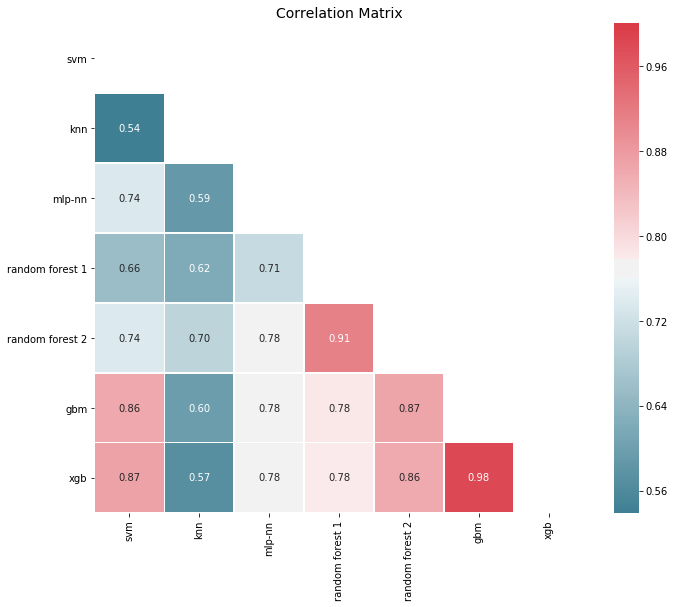

In [78]:
#ML-Ensemble
#Errors are significantly correlated, which is to be expected for models that perform well, 
#since it’s typically the outliers that are hard to get right. However, the model correlations below fall in 
#the 50-80% range, so there is room for model improvement through ensemble.

from mlens.visualization import corrmat

corrmat(P.corr(), inflate=False)
plt.show()

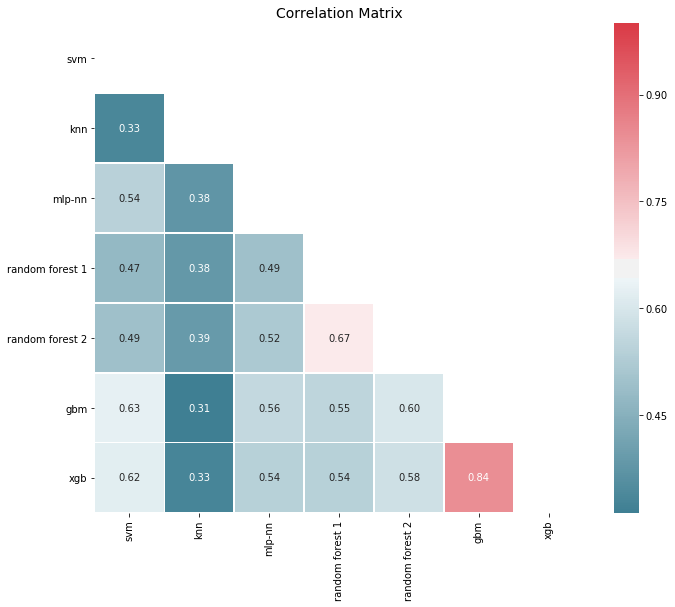

In [79]:
#Looking at error correlations on a class prediction basis:
#Scores at lower, which is more promising

corrmat(P.apply(lambda pred: 1*(pred >= 0.5) - y_val.values).corr(), inflate=False)
plt.show()

In [80]:
print("Ensemble ROC-AUC score: %.3f" % roc_auc_score(y_val, P.mean(axis=1)))

Ensemble ROC-AUC score: 0.928


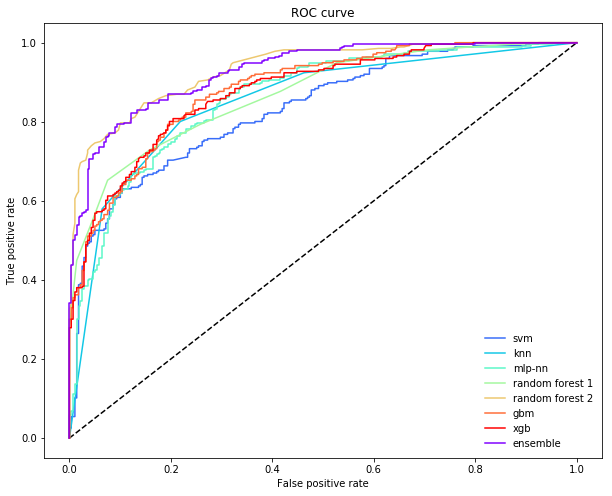

In [81]:
#Looking at ROC curve for all models

from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')

    cm = [plt.cm.rainbow(i)
      for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]

    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(y_val, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

    fpr, tpr, _ = roc_curve(y_val, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)
    plt.show()


plot_roc_curve(y_val, P.values, P.mean(axis=1), list(P.columns), "ensemble")

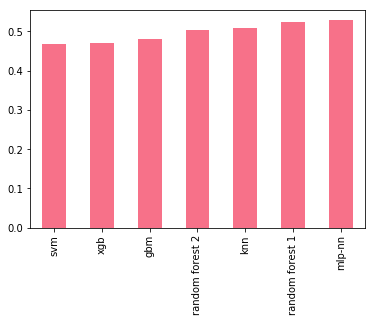

In [82]:
#Ranking of models by 
# A simple check shows that some models perform worse than others.

p = P.apply(lambda x: 1*(x >= 0.5).value_counts(normalize=True))
p.index = ["UNSAFE", "OKAY"]
p.loc["OKAY", :].sort_values().plot(kind="bar")
#plt.axhline(0.25, color="k", linewidth=0.5)
#plt.text(0., 0.23, "True share")
plt.show()

In [83]:
#Improve the Emsemble by removing the worst offender: Naive Bayes

include = [c for c in P.columns if c not in ["svm"]]
print("Truncated ensemble ROC-AUC score: %.3f" % roc_auc_score(y_val, P.loc[:, include].mean(axis=1)))

Truncated ensemble ROC-AUC score: 0.930


### Part 4.d.2 Ensemble Model:

In [84]:
#Define a meta learner

meta_learner = RandomForestClassifier(
#     n_estimators=1000,
#     loss="exponential",
#     max_features=4,
#     max_depth=3,
#     subsample=0.5,
#     learning_rate=0.005,
    random_state=42)

In [85]:
# example of a super learner using the mlens library
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from mlens.ensemble import SuperLearner

# create a list of base-models
def get_models():
    models = list()
    models.append(GaussianNB())
    models.append(SVC(C=100, probability=True))
    models.append(KNeighborsClassifier(n_neighbors=5))
    models.append(LogisticRegression(max_iter=5000,random_state=42))
    models.append(MLPClassifier((80, 10), early_stopping=False, random_state=42,max_iter=1000))
    models.append(GradientBoostingClassifier(random_state=42))
    models.append(RandomForestClassifier(max_features=3, random_state=42))
    models.append(RandomForestClassifier(random_state=42))
    models.append(XGBClassifier())
    
#     models = {
#               'svm': svc,
#               'knn': knn,
#               'naive bayes': nb,
#               'mlp-nn': nn,
#               'random forest 1': rf1,
#               'random forest 2': rf2,
#               'gbm': gb,
#               'logistic': lr,
#               'xgb': xgb
#               }

    return models

# create the super learner
def get_super_learner(X):
    ensemble = SuperLearner(scorer=accuracy_score, folds=10, shuffle=True, sample_size=len(X))
    # add base models
    models = get_models()
    ensemble.add(models)
    # add the meta model
    ensemble.add_meta(LogisticRegression(solver='lbfgs'))
    return ensemble


In [86]:
# create the inputs and outputs
y = df2.target.values
X = df2.drop('target', axis=1).values

# # split
# X, X_val, y, y_val = train_test_split(X, y, test_size=0.50)

# setting up testing and training sets
X, x_val, y, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
print('Train', X.shape, y.shape, 'Test', x_val.shape, y_val.shape)

# create the super learner
ensemble = get_super_learner(X)


# fit the super learner
ensemble.fit(X, y)
# # summarize base learners
print(ensemble.data)
# # make predictions on hold out set
yhat = ensemble.predict(x_val)
print('Super Learner: %.3f' % (accuracy_score(y_val, yhat) * 100))

Train (1665, 22) (1665,) Test (555, 22) (555,)
                                       score-m  score-s   ft-m  ft-s  pt-m  pt-s
layer-1  gaussiannb                       0.59     0.03   0.02  0.00  0.00  0.00
layer-1  gradientboostingclassifier       0.76     0.03   1.94  0.14  0.00  0.01
layer-1  kneighborsclassifier             0.72     0.03   0.02  0.01  0.01  0.01
layer-1  logisticregression               0.67     0.03   9.64  2.29  0.00  0.00
layer-1  mlpclassifier                    0.73     0.02  21.22  4.25  0.00  0.00
layer-1  randomforestclassifier-1         0.84     0.02   1.97  0.35  0.16  0.07
layer-1  randomforestclassifier-2         0.84     0.02   1.40  0.26  0.07  0.03
layer-1  svc                              0.68     0.02   1.97  0.13  0.02  0.01
layer-1  xgbclassifier                    0.76     0.04   0.32  0.08  0.00  0.00

Super Learner: 85.586
